# Time-Series Forecasting for the Traffic Flow and Speed on Highways

This notebook shows the training process of our CNN regression model. We built our deep learning model based on the __PyTorch__ framework and completed the model training through the __Google Colab__.

## Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/hwyTrafficPred

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/hwyTrafficPred


## Import packages

In [2]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from toolkits.datasets import load_next_30min
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

## Build Model

We use the __Convolutional Neural Network (CNN)__ to depict the feature for the time series and the space dependence simultaneously. Each single data is a 4-D tensor with the shape of `[batch, 5, 3, 6]` ([batch, channels, height, width]). 
- `batch`: The batch size for training, we set `batch=1024`. 
- `channels`: There are 5 channels for each single data, and each channel represents five features, including the volume, speed, occupancy, the number of lanes, and the characteristics of the road section.
- `height`: It can also be regarded as the row of the tensor in each channel. The middle row is the target vehicle detector we are concerned about. The first and the last rows represent the upstream and the downstream vehicle detectors.
- `width`: It can also be regarded as the column of the tensor in each channel. Each column records the data in the previous 5, 10, ..., 30 minutes for each feature.

Here's the figure of our model structure. We built 2 convolutional layers and 10 fully-connected layers, and the final output is a tensor with the shape of `[batch, 12]`, respectively representing the average speed and the total volume in the next 5, 10, ..., 30 minutes for the target vehicle detector.

![Model Structure](images/structure.PNG)

In [3]:
class CNNModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.cnnLayer = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=16, kernel_size=(2,2), stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(1, 1, 0),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2,2), stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(1, 1, 0),
        )

        self.fcLayer = nn.Sequential(
            nn.Linear(32 * 1 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 12),
            nn.Sigmoid(),
        )

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(self.device)

    def forward(self, x) -> torch.Tensor:
        x = self.cnnLayer(x)
        x = x.flatten(1)
        x = self.fcLayer(x)
        return x

    def save(self, ckpt_dir: str) -> None:
        torch.save(self.state_dict(), os.path.join(ckpt_dir, 'model.pth'))

    def load(self, ckpt_dir: str) -> None:
        self.load_state_dict(torch.load(os.path.join(ckpt_dir, 'model.pth')))

## Load datasets and prepare dataloaders.

We have randomly split the data for training and validation, and they are approximately 8:2.

In [4]:
# Hyperparams for training
batch_size = 1024
lr = 1e-3
n_epochs = 20

# Prepare datasets and dataloaders
trainDataset, validDataset = load_next_30min(ckpt_dir='./toolkits/next_half_hour_data')
trainLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
validLoader = DataLoader(validDataset, batch_size=batch_size, shuffle=False)

print(f"trainDataset Size: {len(trainDataset)}, validDataset Size: {len(validDataset)}")

trainDataset Size: 6894385, validDataset Size: 1723596


## Start training

In [5]:
model = CNNModel()
optimizer = optim.Adam(params=model.parameters(), lr=lr, weight_decay=1e-8)
train_records, valid_records = [], []

for epoch in range(n_epochs):
    # ========= Training =========
    model.train()

    # Record Info in training
    train_loss = []

    for batch in tqdm(trainLoader):
        X, y = batch
        logits = model(X.to(model.device))
        loss = F.mse_loss(logits, y.to(model.device))

        # Compute gradients and update model params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    # Compute the average train_loss
    avg_loss = sum(train_loss) / len(train_loss)
    train_records.append(avg_loss)
    print(f"[ Train | {epoch + 1:d}/{n_epochs:d} ] loss = {avg_loss:.5f}")

    # ========= Testing =========
    model.eval()

    # Record Info in testing
    valid_loss = []

    for batch in tqdm(validLoader):
        X, y = batch
        with torch.no_grad():
          logits = model(X.to(model.device))

        loss = F.mse_loss(logits, y.to(model.device))

        valid_loss.append(loss.item())

    # Compute the average valid_loss
    avg_loss = sum(valid_loss) / len(valid_loss)
    valid_records.append(avg_loss)
    print(f"[ Valid | {epoch + 1:d}/{n_epochs:d} ] loss = {avg_loss:.5f}")


# Save model after training
model.save('./model/')

  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 1/20 ] loss = 0.00663


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 1/20 ] loss = 0.00577


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 2/20 ] loss = 0.00573


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 2/20 ] loss = 0.00570


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 3/20 ] loss = 0.00559


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 3/20 ] loss = 0.00548


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 4/20 ] loss = 0.00549


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 4/20 ] loss = 0.00538


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 5/20 ] loss = 0.00543


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 5/20 ] loss = 0.00534


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 6/20 ] loss = 0.00539


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 6/20 ] loss = 0.00533


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 7/20 ] loss = 0.00536


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 7/20 ] loss = 0.00531


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 8/20 ] loss = 0.00534


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 8/20 ] loss = 0.00532


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 9/20 ] loss = 0.00531


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 9/20 ] loss = 0.00526


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 10/20 ] loss = 0.00530


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 10/20 ] loss = 0.00527


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 11/20 ] loss = 0.00528


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 11/20 ] loss = 0.00525


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 12/20 ] loss = 0.00527


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 12/20 ] loss = 0.00526


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 13/20 ] loss = 0.00526


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 13/20 ] loss = 0.00523


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 14/20 ] loss = 0.00525


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 14/20 ] loss = 0.00525


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 15/20 ] loss = 0.00524


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 15/20 ] loss = 0.00522


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 16/20 ] loss = 0.00523


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 16/20 ] loss = 0.00521


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 17/20 ] loss = 0.00522


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 17/20 ] loss = 0.00518


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 18/20 ] loss = 0.00521


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 18/20 ] loss = 0.00523


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 19/20 ] loss = 0.00521


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 19/20 ] loss = 0.00521


  0%|          | 0/6733 [00:00<?, ?it/s]

[ Train | 20/20 ] loss = 0.00520


  0%|          | 0/1684 [00:00<?, ?it/s]

[ Valid | 20/20 ] loss = 0.00520


## Visualization for the training process

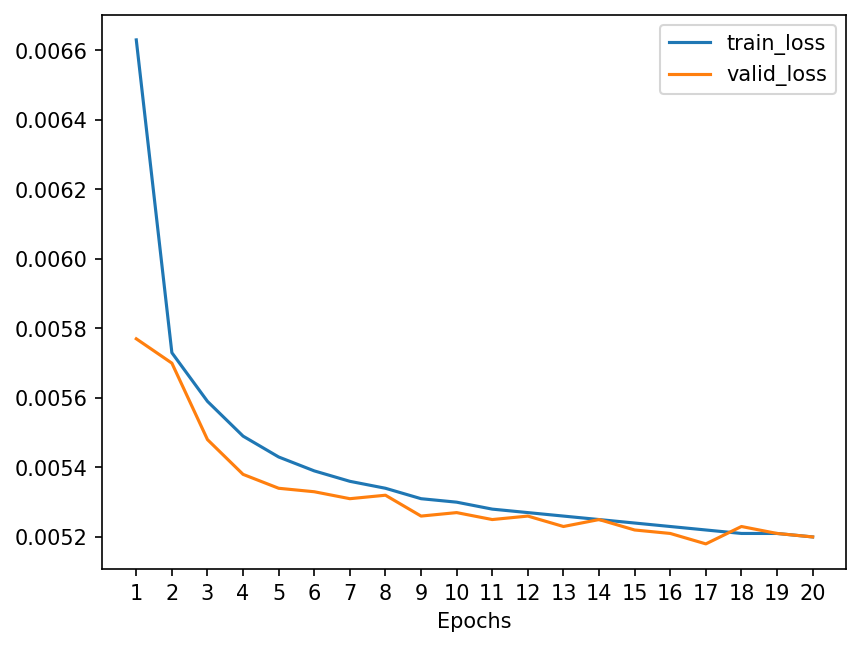

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
%matplotlib inline

plt.plot(train_records, label='train_loss')
plt.plot(valid_records, label='valid_loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(n_epochs), labels=[i for i in range(1, n_epochs+1)])
plt.legend()